ic| np.average(chi0s): 40.352827447084664
ic| chi0s.std()*2: 1.4815056459150022
ic| np.sum(residual): 0.005455470390013754
ic| np.sum(residual_linear): 0.012341819002583883


k_fit:
	c0: 0.24905 +- 0.0030878 
	c1: 0.0050092 +- 0.00011564 
	c2: -0.0039794 +- 0.00010303 
	c3: 2.6081e-05 +- 6.7555e-06 
	c4: -2.9666e-05 +- 6.9862e-06 
	c5: -2.3103e-05 +- 6.2685e-06 
k_fit_linear:
	c0: -0.47462 +- 0.022347 
	c1: 0.0053337 +- 0.00014759 
	c2: -0.003875 +- 0.00014072 
err (2sigma):
[6.17569004e-03 2.31280775e-04 2.06067771e-04 1.35109461e-05
 1.39723328e-05 1.25369927e-05]
err_linear (2sigma):
[0.04469326 0.00029518 0.00028143]
corr:
          0         1         2         3         4         5
0  1.000000  0.159769 -0.122727 -0.641781  0.126540 -0.666068
1  0.159769  1.000000 -0.135617 -0.431720  0.269969 -0.029784
2 -0.122727 -0.135617  1.000000  0.099267 -0.092831  0.341335
3 -0.641781 -0.431720  0.099267  1.000000 -0.201885  0.216590
4  0.126540  0.269969 -0.092831 -0.201885  1.000000 -0.178158
5 -0.666068 -0.029784  0.341335  0.216590 -0.178158  1.000000
corr_linear:
          0         1         2
0  1.000000 -0.989267  0.029199
1 -0.989267  1.000000 -0.1316

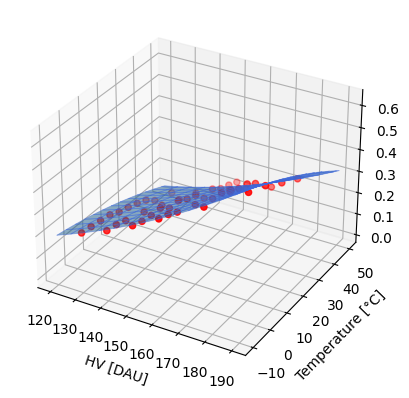

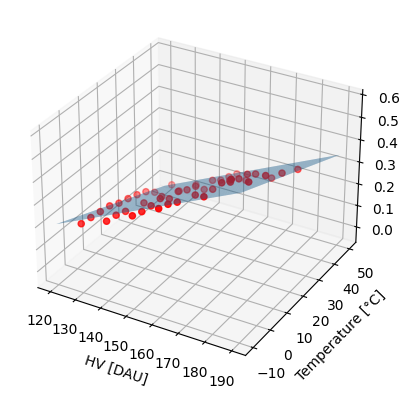

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from icecream import ic

# %matplotlib widget

temp_calib_df = pd.read_csv('../outputs/temp-calib/calib_result.csv')
hvs = temp_calib_df.values[:, 0]
temps = temp_calib_df.values[:, 1]
ks = temp_calib_df.values[:, 2]
chi0s = temp_calib_df.values[:, 3]

temp0 = 20
hv0 = 150

def hvt_func(hvtemp, c0, c1, c2, c3, c4, c5):
    hv, temp = hvtemp
    hv = hv - hv0
    temp = temp - temp0
    return c0 + c1*hv + c2*temp + c3*hv**2 + c4*hv*temp + c5*temp**2

def hvt_func_linear(hvtemp, c0, c1, c2):
    hv, temp = hvtemp
    return c0 + c1*hv + c2*temp

ic(np.average(chi0s))
ic(chi0s.std()*2)

k_fit, pcov = curve_fit(hvt_func, (hvs, temps), ks)
k_fit_linear, pcov_linear = curve_fit(hvt_func_linear, (hvs, temps), ks)

# print(k_fit)
# print(k_fit_linear)
# print(pcov_linear)

err = np.sqrt(np.diag(pcov))
err_linear = np.sqrt(np.diag(pcov_linear))
corr = pcov / np.outer(err, err)
corr_linear = pcov_linear / np.outer(err_linear, err_linear)

def print_fit_params(fit, err):
    for i in range(len(fit)):
        print(f"\tc{i}: {fit[i]:.5} +- {err[i]:.5} ")

print("k_fit:")
print_fit_params(k_fit, err)
print("k_fit_linear:")
print_fit_params(k_fit_linear, err_linear)

print("err (2sigma):")
print(err * 2)
print("err_linear (2sigma):")
print(err_linear * 2)
print("corr:")
print(pd.DataFrame(corr))
print("corr_linear:")
print(pd.DataFrame(corr_linear))

model_hv = np.linspace(120, 190, 100)
model_temp = np.linspace(-10, 50, 100)
model_hv, model_temp = np.meshgrid(model_hv, model_temp)
model_k = hvt_func((model_hv, model_temp), *k_fit)

model_k_linear = hvt_func_linear((model_hv, model_temp), *k_fit_linear)

residual = (ks - hvt_func((hvs, temps), *k_fit))**2
residual_linear = (ks - hvt_func_linear((hvs, temps), *k_fit_linear))**2

ic(np.sum(residual))
ic(np.sum(residual_linear))

chi0_avg = np.average(chi0s)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(hvs, temps, ks, c='r', marker='o')
ax.plot_surface(model_hv, model_temp, model_k, alpha=0.5, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8)
ax.set_xlabel('HV [DAU]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('k')
plt.savefig("../outputs/hvt-calib/hvt_calib_3d.pdf")
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(hvs, temps, ks, c='r', marker='o')
ax.plot_surface(model_hv, model_temp, model_k_linear, alpha=0.5)
ax.set_xlabel('HV [DAU]')
ax.set_ylabel('Temperature [°C]')
ax.set_zlabel('k')
plt.savefig("../outputs/hvt-calib/hvt_calib_lin_3d.pdf")
plt.show()

np.savetxt('../outputs/init_calib.txt', np.concatenate([[chi0_avg], k_fit]))
np.savetxt('../outputs/init_calib_linear.txt', np.concatenate([[chi0_avg], k_fit_linear]))

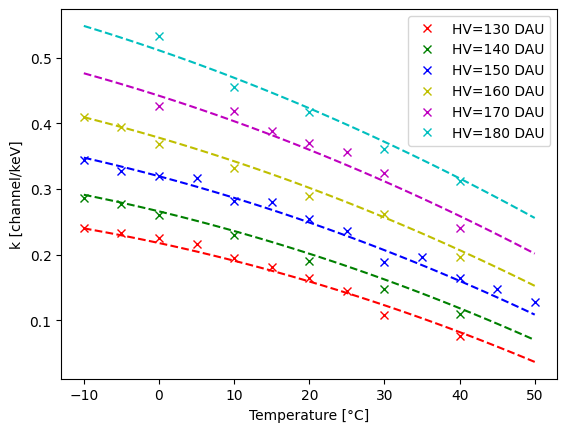

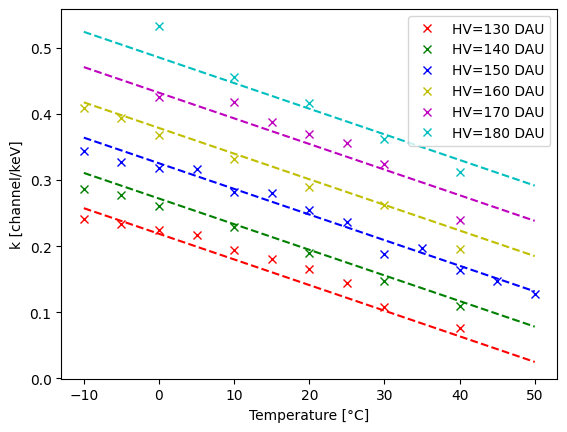

In [2]:
plt.figure()

colors = ['r', 'g', 'b', 'y', 'm', 'c']

for i, hv in enumerate(range(130, 190, 10)):
    hv_filter = hvs == hv
    color = colors[i]
    plt.plot(temps[hv_filter], ks[hv_filter], 'x', color=color, label=f'HV={hv} DAU')
    model_temp = np.linspace(-10, 50, 100)
    model_k = hvt_func((hv, model_temp), *k_fit)
    plt.plot(model_temp, model_k, '--', color=color)

plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('k [channel/keV]')
plt.savefig('../outputs/hvt-calib/hvt_calib.pdf')
plt.show()
    

plt.figure()

for i, hv in enumerate(range(130, 190, 10)):
    hv_filter = hvs == hv
    color = colors[i]
    plt.plot(temps[hv_filter], ks[hv_filter], 'x', color=color, label=f'HV={hv} DAU')
    model_temp = np.linspace(-10, 50, 100)
    model_k = hvt_func_linear((hv, model_temp), *k_fit_linear)
    plt.plot(model_temp, model_k, '--', color=color)

plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('k [channel/keV]')
plt.savefig('../outputs/hvt-calib/hvt_calib_linear.pdf')
plt.show()

## Temperature compensation

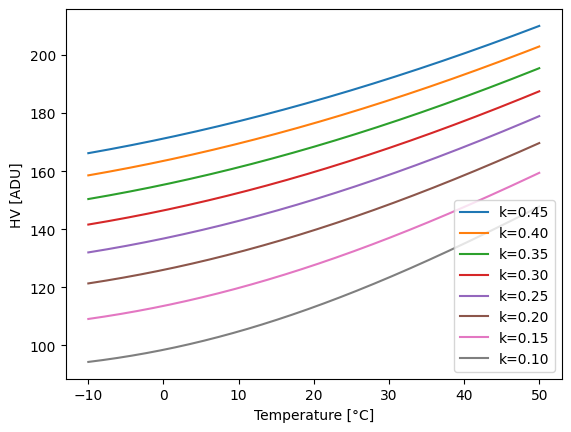

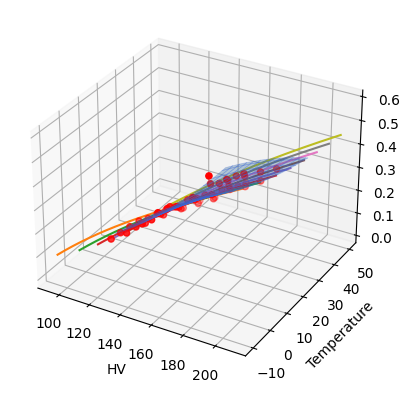

In [3]:
def get_compensation_hv(temp, target_k, k0, c1, c2, c3, c4, c5):
    temp = temp - temp0
    
    D = (c1 + c4 * temp)**2 - 4 * c3 * (k0 - target_k + c2 * temp + c5 * temp**2)
    root1 = (-c1 - c4 * temp + np.sqrt(D)) / (2 * c3)
    root2 = (-c1 - c4 * temp - np.sqrt(D)) / (2 * c3)
    result = root1 + hv0# = root1 if np.abs(root1 - hv0) < np.abs(root2 - hv0) else root2
    return result

tempcomp_ks = np.arange(0.1, 0.5, 0.05)
# tempcomp_ks = [0.3]
tempcomp_temps = np.linspace(-10, 50, 500)
plt.figure()
for target_k in tempcomp_ks[::-1]:
    comp_hvs = get_compensation_hv(tempcomp_temps, target_k, *k_fit)
    plt.plot(tempcomp_temps, comp_hvs, '-', label=f'k={target_k:.2f}')
plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('HV [ADU]')
plt.savefig('../outputs/tempcomp_curves.pdf')
plt.show()
# get_compensation_hv(20, 0.1, *k_fit)

model3d_hv = np.linspace(120, 190, 100)
model3d_temp = np.linspace(0, 50, 100)
model3d_hv, model3d_temp = np.meshgrid(model3d_hv, model3d_temp)
model3d_k = hvt_func((model3d_hv, model3d_temp), *k_fit)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(hvs, temps, ks, c='r', marker='o')
ax.plot_surface(model3d_hv, model3d_temp, model3d_k, alpha=0.3, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8)
for target_k in tempcomp_ks:
    comp_hvs = get_compensation_hv(tempcomp_temps, target_k, *k_fit)
    ax.plot(comp_hvs, tempcomp_temps, np.full_like(tempcomp_temps, target_k), '-', label=f'k={target_k:.2f}')
ax.set_xlabel('HV')
ax.set_ylabel('Temperature')
ax.set_zlabel('k')
plt.show()



## Spectrum plotter (with energies)

In [4]:
def get_file_path(isotope: str, temp: float | str, ch: int, hv: int, dir: str):
    temp_str = temp if isinstance(temp, str) else f'{int(temp)}'
    return f"../data/{dir}/{isotope}/t_{temp_str}/ch_{ch}/hv_{hv}.csv"

def load_spec(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    
    df = pd.read_csv(filepath)
    exp_times = df.values[:, 0]
    total_exposure = np.sum(exp_times)
    spec_exposures = df.values[:, 4:]
    spec = np.sum(spec_exposures * np.tile(exp_times, (spec_exposures.shape[1], 1)).T, axis=0) / total_exposure
    return spec

def load_partial_specs(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    total_exposure = np.sum(df.values[:, 0])
    spec_exposures = df.values[:, 4:]
    return spec_exposures

channels = np.arange(0, 256)

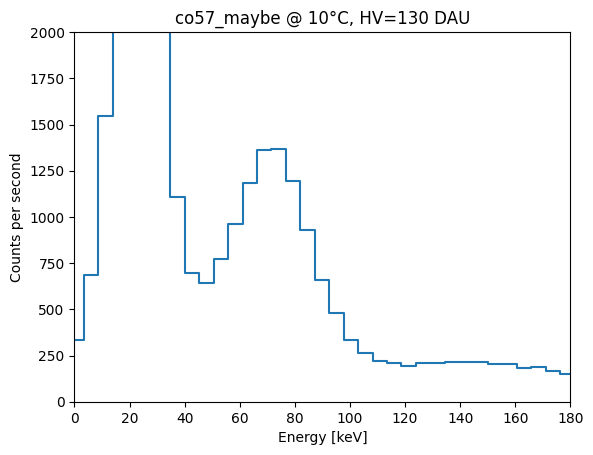

In [6]:
isotope = 'co57_maybe'
dir = 'prague'
hv = 130
temp = 10
ch = 0

spec = load_spec(isotope, temp, ch, hv, dir)
channels = np.arange(0, 256)
k = hvt_func((hv, temp), *k_fit)
energies = (channels - chi0_avg) / k

plt.figure()
plt.step(energies, spec)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts per second')
plt.title(f'{isotope} @ {temp}°C, HV={hv} DAU')
plt.xlim(0, 180)
plt.ylim(0, 2000)
# plt.savefig('outputs/eu152_spec.pdf')
plt.show()